In [1]:
!pip install pandas numpy matplotlib scikit-learn imbalanced-learn

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [4]:
df_train = pd.read_csv("/kaggle/input/uit-vctsd1/df_train_clean.csv")
df_dev   = pd.read_csv("/kaggle/input/uit-vctsd1/df_dev_clean.csv")
df_test  = pd.read_csv("/kaggle/input/uit-vctsd1/df_test_clean.csv")

In [5]:
for df in (df_train, df_dev, df_test):
    df['content'] = df['content'].fillna('').astype(str)

# Toxicity

In [6]:
X_train, y_train = df_train["content"].fillna("").tolist(), df_train["Toxicity"].tolist()
X_dev,   y_dev   = df_dev["content"].fillna("").tolist(),   df_dev["Toxicity"].tolist()
X_test,  y_test  = df_test["content"].fillna("").tolist(),  df_test["Toxicity"].tolist()

In [12]:
emo_df = pd.read_excel("/kaggle/input/uit-vctsd1/VnEmoLex.xlsx", sheet_name=0)
drop_cols = [c for c in emo_df.columns if "Unnamed" in c]
emo_df.drop(columns=drop_cols, inplace=True)

In [13]:
# Xử lý tên cột và giá trị
emo_df = emo_df.fillna(0)

# Danh sách các cột cảm xúc cần gộp
toxic_cols = [
    'Negative',
    'Anger\n/ tức giận',
    'Disgust\n/ chán ghét',
    'Fear\n/ sợ hãi',
    'Sadness\n/ buồn bã'
]

non_toxic_cols = [
    'Positive',
    'Anticipation\n/ Hi vọng',
    'Trust\n/ tin tưởng',
    'Joy\n/ thích thú',
]

# Chuyển kiểu dữ liệu các cột thành int
emo_df[toxic_cols + non_toxic_cols] = emo_df[toxic_cols + non_toxic_cols].astype(int)

# Tạo cột mới: nếu có ít nhất 1 flag toxic → toxic = 1
emo_df['toxic'] = emo_df[toxic_cols].max(axis=1)

# Tạo cột mới: nếu có ít nhất 1 flag non-toxic → non_toxic = 1
emo_df['non_toxic'] = emo_df[non_toxic_cols].max(axis=1)

# Lấy ra các cột cần thiết
emo_binary_df = emo_df[['Vietnamese', 'toxic', 'non_toxic']].rename(columns={'Vietnamese': 'words'})

# Xem trước
print(emo_binary_df.head())

                  words  toxic  non_toxic
0             Danh nhân      0          1
1            danh tiếng      0          1
2  nghệ thuật nhạc kịch      0          1
3          sự nổi tiếng      1          1
4               bất tận      1          1


In [23]:
lex_dict = {
    1: set(emo_binary_df.query('toxic == 1 and non_toxic == 0')['words']),   # chỉ toxic
    0: set(emo_binary_df.query('non_toxic == 1 and toxic == 0')['words'])    # chỉ non-toxic
}
class_labels = ["Non-Toxic", "Toxic"]

In [24]:
class VnEmoLexiconCounts(BaseEstimator, TransformerMixin):
    def __init__(self, lexicon_dict):
        self.lex = lexicon_dict
        self.labels = sorted(lexicon_dict.keys())
    def fit(self, X, y=None): return self
    def transform(self, X):
        feats = []
        for doc in X:
            ws = doc.lower().split()
            counts = [sum(1 for w in ws if w in self.lex[lbl]) for lbl in self.labels]
            feats.append(counts)
        return np.array(feats, dtype=np.float32)

In [25]:
word_vect  = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.8)
char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=5)
tfidf_union= FeatureUnion([("w",word_vect),("c",char_vect)])
vnelex     = VnEmoLexiconCounts(lex_dict)

In [26]:
full_features = FeatureUnion([
    ("tfidf", tfidf_union),
    ("vnemolex", vnelex)
])

In [27]:
smote = SMOTE(random_state=42)

In [28]:
base_models = {
    "SVM (linear)"       : SVC(kernel="linear", C=1, class_weight="balanced", probability=True, random_state=42),
    "LogisticRegression" : LogisticRegression(C=1, max_iter=1000, class_weight="balanced", random_state=42),
    "RandomForest"       : RandomForestClassifier(n_estimators=100, random_state=42),
    "DecisionTree"       : DecisionTreeClassifier(random_state=42),
    "NaiveBayes"         : MultinomialNB()
}

In [30]:
pipelines = {
    name: ImbPipeline([
        ('features', full_features),
        ('smote',    smote),
        ('clf',      model),
    ])
    for name, model in base_models.items()
}

In [31]:
def evaluate_model(pipe, X, y, split_name, model_name, class_labels):
    y_pred = pipe.predict(X)
    print(f"\n--- {model_name} on {split_name} ---")
    print(classification_report(
        y, y_pred,
        labels=[0,1],  # chỉ 2 nhãn cho toxic / non-toxic
        target_names=class_labels,
        zero_division=0,
        digits=4
    ))
    cm = confusion_matrix(y, y_pred, labels=[0,1])
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix ({split_name})")
    plt.colorbar()
    ticks = np.arange(len(class_labels))
    plt.xticks(ticks, class_labels, rotation=45)
    plt.yticks(ticks, class_labels)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color=color)

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


======== Training SVM (linear) ========

--- SVM (linear) on Train ---
              precision    recall  f1-score   support

   Non-Toxic     1.0000    0.9978    0.9989      6241
       Toxic     0.9819    1.0000    0.9909       759

    accuracy                         0.9980      7000
   macro avg     0.9909    0.9989    0.9949      7000
weighted avg     0.9980    0.9980    0.9980      7000



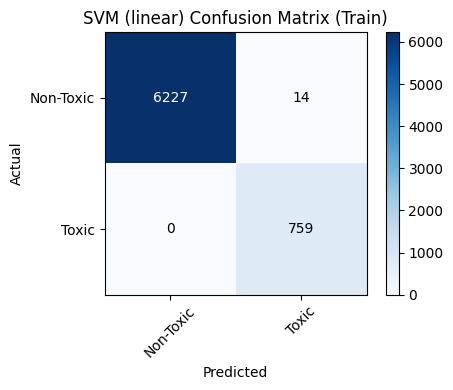


--- SVM (linear) on Dev ---
              precision    recall  f1-score   support

   Non-Toxic     0.9159    0.9491    0.9322      1768
       Toxic     0.4643    0.3362    0.3900       232

    accuracy                         0.8780      2000
   macro avg     0.6901    0.6427    0.6611      2000
weighted avg     0.8635    0.8780    0.8693      2000



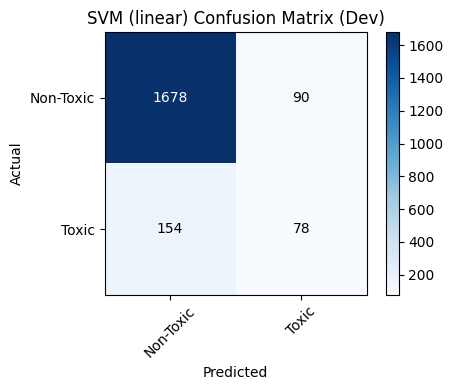


--- SVM (linear) on Test ---
              precision    recall  f1-score   support

   Non-Toxic     0.9258    0.9393    0.9325       890
       Toxic     0.4433    0.3909    0.4155       110

    accuracy                         0.8790      1000
   macro avg     0.6846    0.6651    0.6740      1000
weighted avg     0.8727    0.8790    0.8756      1000



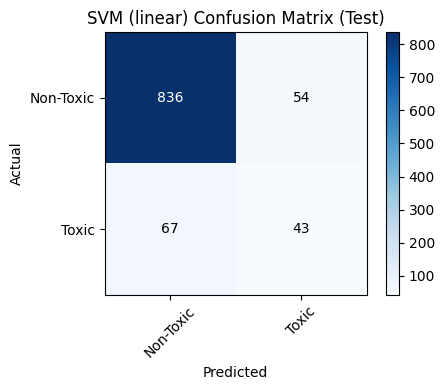


======== Training LogisticRegression ========

--- LogisticRegression on Train ---
              precision    recall  f1-score   support

   Non-Toxic     0.9980    0.9720    0.9848      6241
       Toxic     0.8102    0.9842    0.8888       759

    accuracy                         0.9733      7000
   macro avg     0.9041    0.9781    0.9368      7000
weighted avg     0.9777    0.9733    0.9744      7000



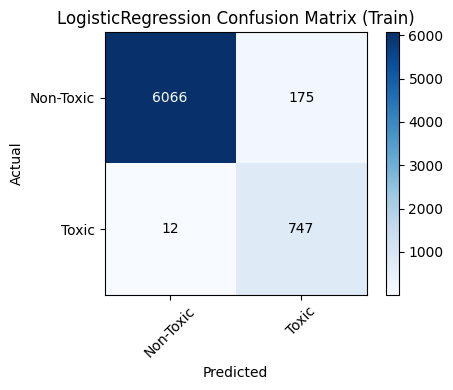


--- LogisticRegression on Dev ---
              precision    recall  f1-score   support

   Non-Toxic     0.9302    0.9197    0.9249      1768
       Toxic     0.4365    0.4741    0.4545       232

    accuracy                         0.8680      2000
   macro avg     0.6834    0.6969    0.6897      2000
weighted avg     0.8729    0.8680    0.8704      2000



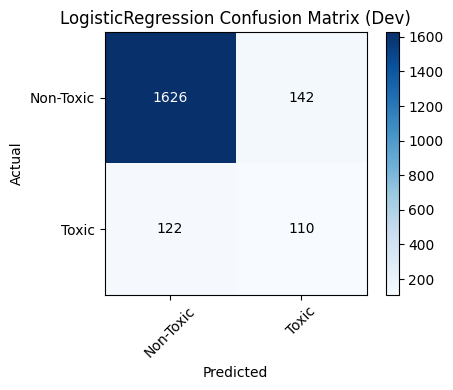


--- LogisticRegression on Test ---
              precision    recall  f1-score   support

   Non-Toxic     0.9408    0.9112    0.9258       890
       Toxic     0.4275    0.5364    0.4758       110

    accuracy                         0.8700      1000
   macro avg     0.6842    0.7238    0.7008      1000
weighted avg     0.8844    0.8700    0.8763      1000



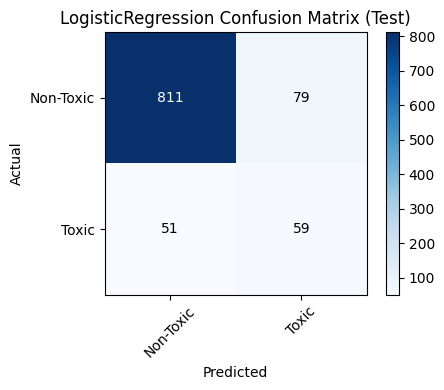


======== Training RandomForest ========

--- RandomForest on Train ---
              precision    recall  f1-score   support

   Non-Toxic     1.0000    1.0000    1.0000      6241
       Toxic     1.0000    1.0000    1.0000       759

    accuracy                         1.0000      7000
   macro avg     1.0000    1.0000    1.0000      7000
weighted avg     1.0000    1.0000    1.0000      7000



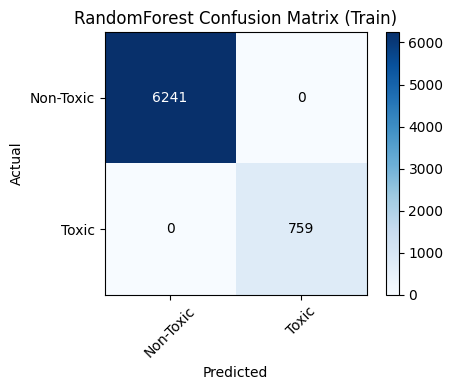


--- RandomForest on Dev ---
              precision    recall  f1-score   support

   Non-Toxic     0.8946    0.9791    0.9349      1768
       Toxic     0.4308    0.1207    0.1886       232

    accuracy                         0.8795      2000
   macro avg     0.6627    0.5499    0.5617      2000
weighted avg     0.8408    0.8795    0.8483      2000



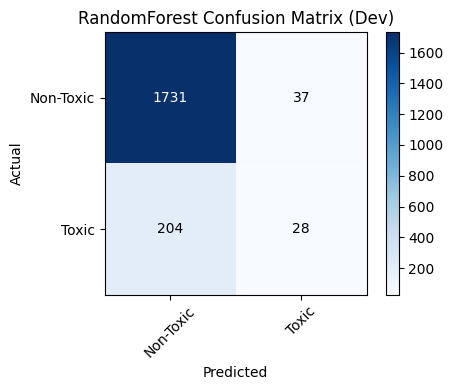


--- RandomForest on Test ---
              precision    recall  f1-score   support

   Non-Toxic     0.9095    0.9820    0.9444       890
       Toxic     0.5897    0.2091    0.3087       110

    accuracy                         0.8970      1000
   macro avg     0.7496    0.5956    0.6265      1000
weighted avg     0.8743    0.8970    0.8744      1000



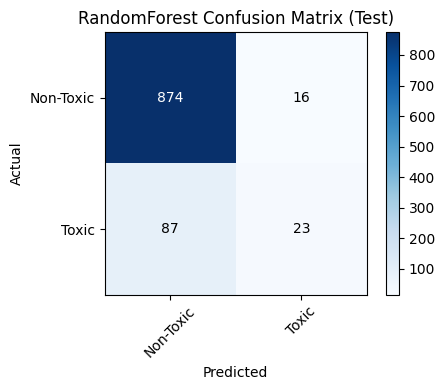


======== Training DecisionTree ========

--- DecisionTree on Train ---
              precision    recall  f1-score   support

   Non-Toxic     1.0000    1.0000    1.0000      6241
       Toxic     1.0000    1.0000    1.0000       759

    accuracy                         1.0000      7000
   macro avg     1.0000    1.0000    1.0000      7000
weighted avg     1.0000    1.0000    1.0000      7000



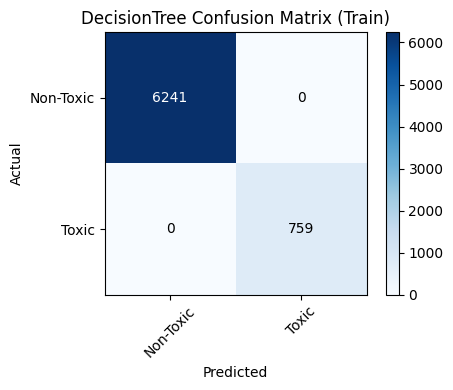


--- DecisionTree on Dev ---
              precision    recall  f1-score   support

   Non-Toxic     0.9041    0.8637    0.8834      1768
       Toxic     0.2251    0.3017    0.2578       232

    accuracy                         0.7985      2000
   macro avg     0.5646    0.5827    0.5706      2000
weighted avg     0.8253    0.7985    0.8109      2000



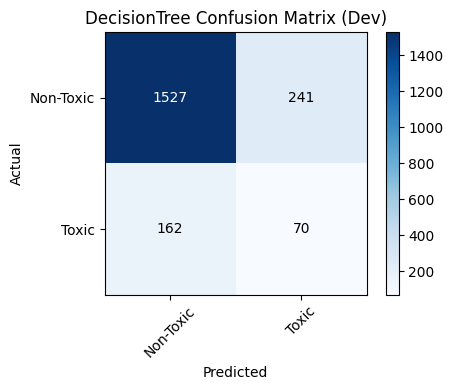


--- DecisionTree on Test ---
              precision    recall  f1-score   support

   Non-Toxic     0.9122    0.8640    0.8875       890
       Toxic     0.2293    0.3273    0.2697       110

    accuracy                         0.8050      1000
   macro avg     0.5708    0.5957    0.5786      1000
weighted avg     0.8371    0.8050    0.8195      1000



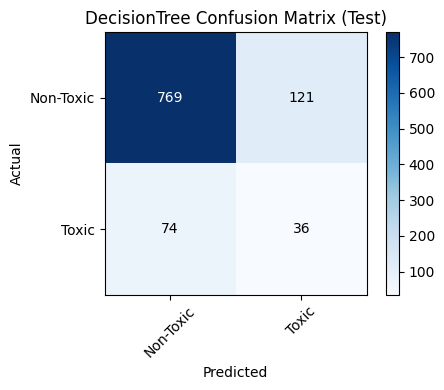


======== Training NaiveBayes ========

--- NaiveBayes on Train ---
              precision    recall  f1-score   support

   Non-Toxic     0.9938    0.8433    0.9124      6241
       Toxic     0.4261    0.9565    0.5895       759

    accuracy                         0.8556      7000
   macro avg     0.7099    0.8999    0.7509      7000
weighted avg     0.9322    0.8556    0.8774      7000



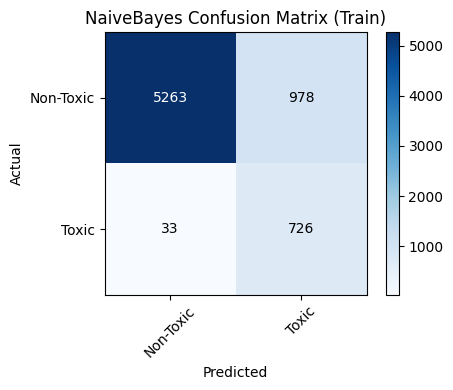


--- NaiveBayes on Dev ---
              precision    recall  f1-score   support

   Non-Toxic     0.9455    0.7952    0.8639      1768
       Toxic     0.2943    0.6509    0.4054       232

    accuracy                         0.7785      2000
   macro avg     0.6199    0.7231    0.6346      2000
weighted avg     0.8700    0.7785    0.8107      2000



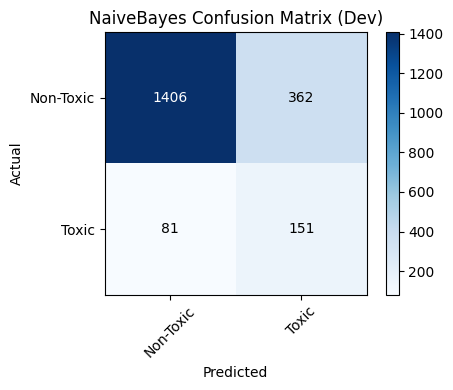


--- NaiveBayes on Test ---
              precision    recall  f1-score   support

   Non-Toxic     0.9489    0.7921    0.8634       890
       Toxic     0.2802    0.6545    0.3924       110

    accuracy                         0.7770      1000
   macro avg     0.6145    0.7233    0.6279      1000
weighted avg     0.8753    0.7770    0.8116      1000



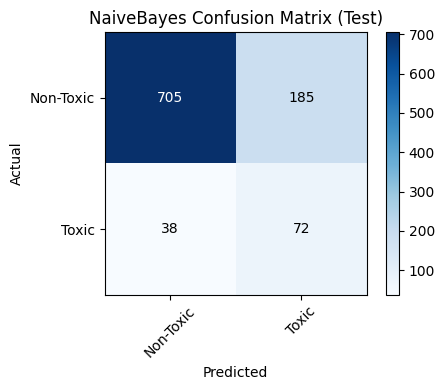

In [32]:
for name, pipe in pipelines.items():
    print(f"\n======== Training {name} ========")
    pipe.fit(X_train, y_train)
    for split_name, (X_split, y_split) in [
        ("Train", (X_train, y_train)),
        ("Dev",   (X_dev,   y_dev)),
        ("Test",  (X_test,  y_test)),
    ]:
        evaluate_model(pipe, X_split, y_split, split_name, name, class_labels)

# Constructiveness

In [34]:
X_train, y_train = df_train["content"].fillna("").tolist(), df_train["Constructiveness"].tolist()
X_dev,   y_dev   = df_dev["content"].fillna("").tolist(),   df_dev["Constructiveness"].tolist()
X_test,  y_test  = df_test["content"].fillna("").tolist(),  df_test["Constructiveness"].tolist()

In [35]:
emo_df = pd.read_excel("/kaggle/input/uit-vctsd1/VnEmoLex.xlsx", sheet_name=0)
drop_cols = [c for c in emo_df.columns if "Unnamed" in c]
emo_df.drop(columns=drop_cols, inplace=True)

In [41]:
# Điền giá trị thiếu bằng 0
emo_df = emo_df.fillna(0)

# Danh sách cảm xúc gợi ý cho phát ngôn xây dựng
constructive_cols = [
    'Positive'
]

# Danh sách cảm xúc gợi ý cho phát ngôn không xây dựng
non_constructive_cols = [
    'Negative'
]

# Ép kiểu int cho các cột cảm xúc
emo_df[constructive_cols + non_constructive_cols] = emo_df[constructive_cols + non_constructive_cols].astype(int)

# Tạo nhãn: nếu có ít nhất một cảm xúc xây dựng → là constructive
emo_df['constructive'] = emo_df[constructive_cols].max(axis=1)

# Tạo nhãn: nếu có ít nhất một cảm xúc không xây dựng → là non_constructive
emo_df['non_constructive'] = emo_df[non_constructive_cols].max(axis=1)

# Lấy các cột cần thiết
emo_constructive_df = emo_df[['Vietnamese', 'constructive', 'non_constructive']].rename(columns={'Vietnamese': 'words'})

# Xem trước
print(emo_constructive_df.head())


                  words  constructive  non_constructive
0             Danh nhân             1                 0
1            danh tiếng             1                 0
2  nghệ thuật nhạc kịch             0                 0
3          sự nổi tiếng             1                 1
4               bất tận             0                 0


In [43]:
lex_dict = {
    1: set(emo_constructive_df.query('constructive == 1')['words']),           # từ constructive
    0: set(emo_constructive_df.query('non_constructive == 1')['words'])        # từ non-constructive
}

class_labels = ["Non-Constructive", "Constructive"]

In [44]:
class VnEmoLexiconCounts(BaseEstimator, TransformerMixin):
    def __init__(self, lexicon_dict):
        self.lex = lexicon_dict
        self.labels = sorted(lexicon_dict.keys())
    def fit(self, X, y=None): return self
    def transform(self, X):
        feats = []
        for doc in X:
            ws = doc.lower().split()
            counts = [sum(1 for w in ws if w in self.lex[lbl]) for lbl in self.labels]
            feats.append(counts)
        return np.array(feats, dtype=np.float32)

In [45]:
word_vect  = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.8)
char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=5)
tfidf_union= FeatureUnion([("w",word_vect),("c",char_vect)])
vnelex     = VnEmoLexiconCounts(lex_dict)

In [47]:
full_features = FeatureUnion([
    ("tfidf", tfidf_union),
    ("vnemolex", vnelex)
])

In [49]:
smote = SMOTE(random_state=42)

In [50]:
base_models = {
    "SVM (linear)"       : SVC(kernel="linear", C=1, class_weight="balanced", probability=True, random_state=42),
    "LogisticRegression" : LogisticRegression(C=1, max_iter=1000, class_weight="balanced", random_state=42),
    "RandomForest"       : RandomForestClassifier(n_estimators=100, random_state=42),
    "DecisionTree"       : DecisionTreeClassifier(random_state=42),
    "NaiveBayes"         : MultinomialNB()
}

In [51]:
pipelines = {
    name: ImbPipeline([
        ('features', full_features),
        ('smote',    smote),
        ('clf',      model),
    ])
    for name, model in base_models.items()
}

In [52]:
def evaluate_model(pipe, X, y, split_name, model_name, class_labels):
    y_pred = pipe.predict(X)
    print(f"\n--- {model_name} on {split_name} ---")
    print(classification_report(
        y, y_pred,
        labels=[0,1],  # chỉ 2 nhãn cho toxic / non-toxic
        target_names=class_labels,
        zero_division=0,
        digits=4
    ))
    cm = confusion_matrix(y, y_pred, labels=[0,1])
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix ({split_name})")
    plt.colorbar()
    ticks = np.arange(len(class_labels))
    plt.xticks(ticks, class_labels, rotation=45)
    plt.yticks(ticks, class_labels)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color=color)

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


======== Training SVM (linear) ========

--- SVM (linear) on Train ---
                  precision    recall  f1-score   support

Non-Constructive     0.9841    0.9764    0.9802      4497
    Constructive     0.9582    0.9716    0.9649      2503

        accuracy                         0.9747      7000
       macro avg     0.9712    0.9740    0.9726      7000
    weighted avg     0.9748    0.9747    0.9748      7000



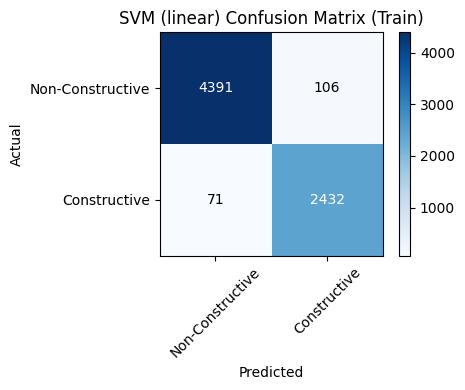


--- SVM (linear) on Dev ---
                  precision    recall  f1-score   support

Non-Constructive     0.8262    0.8379    0.8320      1271
    Constructive     0.7103    0.6927    0.7014       729

        accuracy                         0.7850      2000
       macro avg     0.7682    0.7653    0.7667      2000
    weighted avg     0.7840    0.7850    0.7844      2000



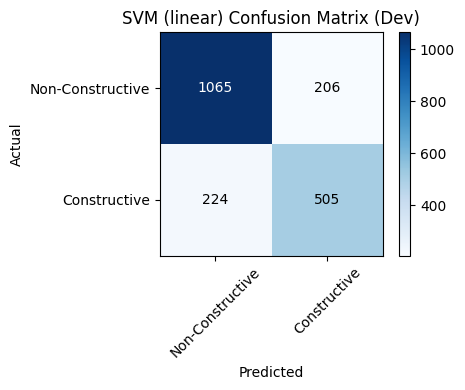


--- SVM (linear) on Test ---
                  precision    recall  f1-score   support

Non-Constructive     0.8479    0.8239    0.8357       636
    Constructive     0.7068    0.7418    0.7239       364

        accuracy                         0.7940      1000
       macro avg     0.7774    0.7828    0.7798      1000
    weighted avg     0.7965    0.7940    0.7950      1000



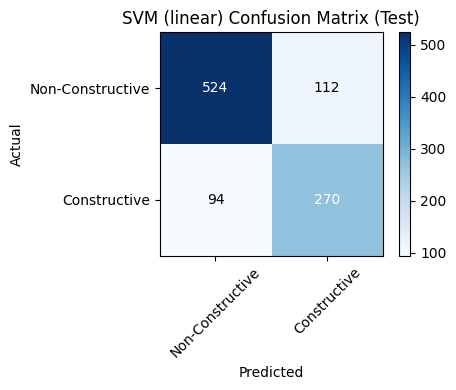


======== Training LogisticRegression ========

--- LogisticRegression on Train ---
                  precision    recall  f1-score   support

Non-Constructive     0.9472    0.9260    0.9365      4497
    Constructive     0.8721    0.9073    0.8894      2503

        accuracy                         0.9193      7000
       macro avg     0.9097    0.9166    0.9129      7000
    weighted avg     0.9204    0.9193    0.9196      7000



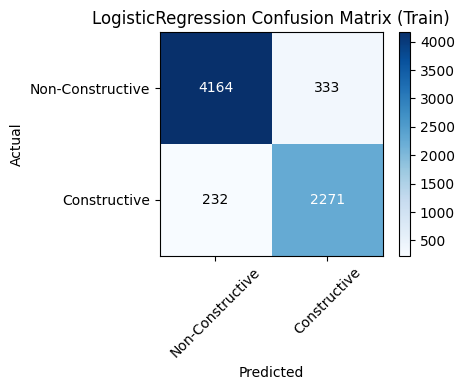


--- LogisticRegression on Dev ---
                  precision    recall  f1-score   support

Non-Constructive     0.8441    0.8395    0.8418      1271
    Constructive     0.7228    0.7298    0.7263       729

        accuracy                         0.7995      2000
       macro avg     0.7835    0.7846    0.7840      2000
    weighted avg     0.7999    0.7995    0.7997      2000



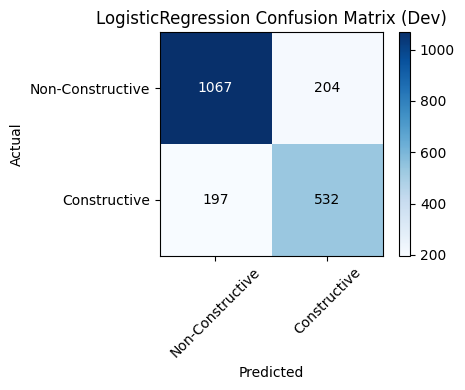


--- LogisticRegression on Test ---
                  precision    recall  f1-score   support

Non-Constructive     0.8796    0.8270    0.8525       636
    Constructive     0.7264    0.8022    0.7624       364

        accuracy                         0.8180      1000
       macro avg     0.8030    0.8146    0.8075      1000
    weighted avg     0.8238    0.8180    0.8197      1000



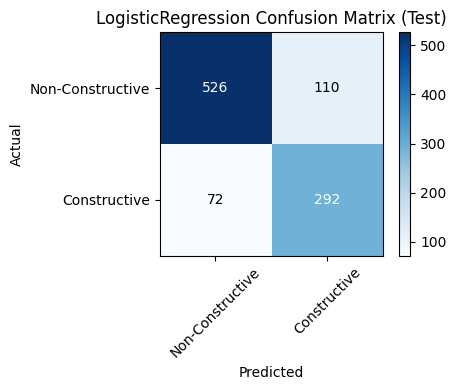


======== Training RandomForest ========

--- RandomForest on Train ---
                  precision    recall  f1-score   support

Non-Constructive     0.9998    0.9996    0.9997      4497
    Constructive     0.9992    0.9996    0.9994      2503

        accuracy                         0.9996      7000
       macro avg     0.9995    0.9996    0.9995      7000
    weighted avg     0.9996    0.9996    0.9996      7000



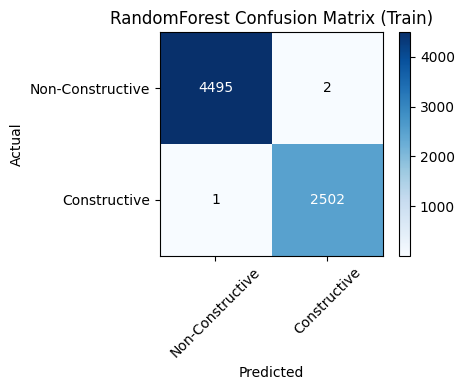


--- RandomForest on Dev ---
                  precision    recall  f1-score   support

Non-Constructive     0.8125    0.8765    0.8433      1271
    Constructive     0.7504    0.6475    0.6951       729

        accuracy                         0.7930      2000
       macro avg     0.7815    0.7620    0.7692      2000
    weighted avg     0.7899    0.7930    0.7893      2000



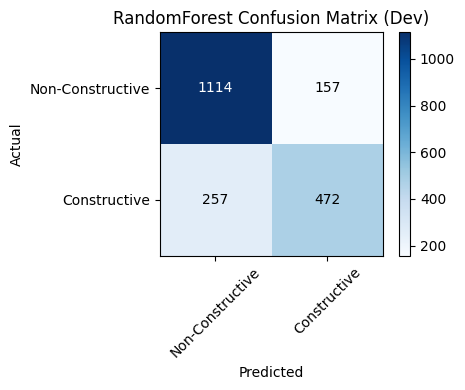


--- RandomForest on Test ---
                  precision    recall  f1-score   support

Non-Constructive     0.8249    0.8664    0.8451       636
    Constructive     0.7440    0.6786    0.7098       364

        accuracy                         0.7980      1000
       macro avg     0.7844    0.7725    0.7774      1000
    weighted avg     0.7954    0.7980    0.7958      1000



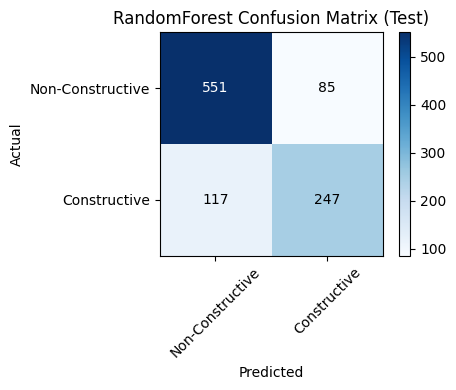


======== Training DecisionTree ========

--- DecisionTree on Train ---
                  precision    recall  f1-score   support

Non-Constructive     0.9993    1.0000    0.9997      4497
    Constructive     1.0000    0.9988    0.9994      2503

        accuracy                         0.9996      7000
       macro avg     0.9997    0.9994    0.9995      7000
    weighted avg     0.9996    0.9996    0.9996      7000



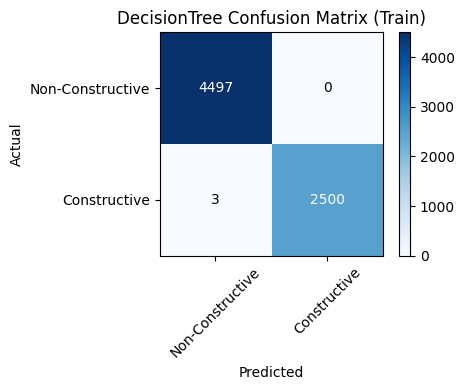


--- DecisionTree on Dev ---
                  precision    recall  f1-score   support

Non-Constructive     0.7747    0.7655    0.7701      1271
    Constructive     0.5995    0.6118    0.6056       729

        accuracy                         0.7095      2000
       macro avg     0.6871    0.6887    0.6878      2000
    weighted avg     0.7108    0.7095    0.7101      2000



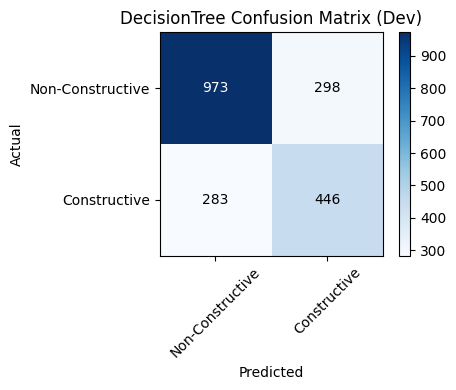


--- DecisionTree on Test ---
                  precision    recall  f1-score   support

Non-Constructive     0.7724    0.7736    0.7730       636
    Constructive     0.6033    0.6016    0.6025       364

        accuracy                         0.7110      1000
       macro avg     0.6878    0.6876    0.6877      1000
    weighted avg     0.7108    0.7110    0.7109      1000



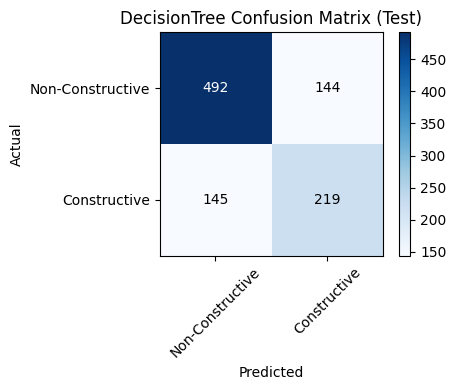


======== Training NaiveBayes ========

--- NaiveBayes on Train ---
                  precision    recall  f1-score   support

Non-Constructive     0.9367    0.6676    0.7795      4497
    Constructive     0.6061    0.9189    0.7304      2503

        accuracy                         0.7574      7000
       macro avg     0.7714    0.7932    0.7550      7000
    weighted avg     0.8184    0.7574    0.7620      7000



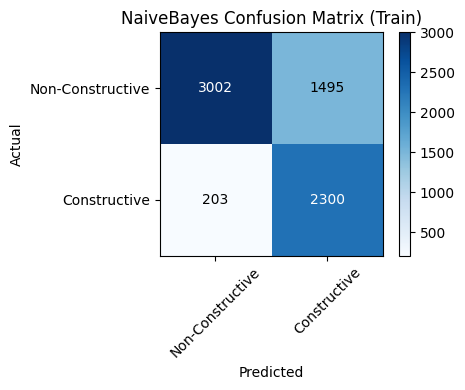


--- NaiveBayes on Dev ---
                  precision    recall  f1-score   support

Non-Constructive     0.8848    0.5437    0.6735      1271
    Constructive     0.5242    0.8765    0.6561       729

        accuracy                         0.6650      2000
       macro avg     0.7045    0.7101    0.6648      2000
    weighted avg     0.7533    0.6650    0.6671      2000



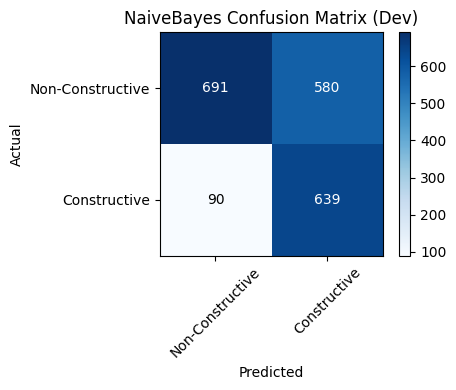


--- NaiveBayes on Test ---
                  precision    recall  f1-score   support

Non-Constructive     0.9030    0.5708    0.6994       636
    Constructive     0.5435    0.8929    0.6757       364

        accuracy                         0.6880      1000
       macro avg     0.7232    0.7318    0.6875      1000
    weighted avg     0.7721    0.6880    0.6908      1000



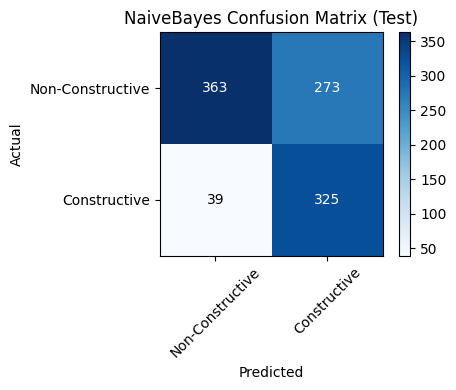

In [53]:
for name, pipe in pipelines.items():
    print(f"\n======== Training {name} ========")
    pipe.fit(X_train, y_train)
    for split_name, (X_split, y_split) in [
        ("Train", (X_train, y_train)),
        ("Dev",   (X_dev,   y_dev)),
        ("Test",  (X_test,  y_test)),
    ]:
        evaluate_model(pipe, X_split, y_split, split_name, name, class_labels)